# Importing Packages

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Loading the Dataset

In [3]:
Data_train = pd.read_csv("train.csv")

# Data Cleaning

In [4]:
#Converting the date column to Datetime Format
Data_train['Date'] = pd.to_datetime(Data_train['Date'], format = '%Y-%m-%d')
#Date column as index and fill NA values with string NULL
Data_train.set_index("Date",inplace= True)
#Replacing null values with the string 'Null'
Data_train['Province_State'] = Data_train['Province_State'].fillna('Null', inplace = True)
Data_train.drop('Id',axis=1,inplace=True)
#Converting Categorical value into Numerical Value
LE = LabelEncoder()
Data_train['Province_State'] = LE.fit_transform(Data_train['Province_State'])
Data_train['Country_Region'] = LE.fit_transform(Data_train['Country_Region'])

# Data Preprocessing

In [5]:
#Normalizing the input variables
train_val = Data_train.values
train_val = train_val.astype('float32')
scale = MinMaxScaler(feature_range=(0,1))
train_scaled = scale.fit_transform(train_val)

In [6]:
#Function to convert Time series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]  
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
train_reframed = series_to_supervised(train_scaled,1,1)
train_reframed.drop(train_reframed.columns[[4,5]], axis=1, inplace=True)

# Splitting the Dataset into Train and Validation

In [12]:
#split the dataset into train and validation
values = train_reframed.values
train_size = int(len(values) * 0.70)
train = values[:train_size, :]
validation = values[train_size:, :]
#split the input and Outputs for cases & Fatalities
train_X, train_case, train_fatalities = train[:, :-2], train[:, -2], train[:, -1]
validation_X, validation_case, validation_fatalities = validation[:, :-2], validation[:, -2], validation[:, -1]

# Data Modelling

In [13]:
#reshape the inputs into 3 Dimensional
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
validation_X = validation_X.reshape((validation_X.shape[0], 1, validation_X.shape[1]))
print(train_X.shape, train_case.shape, train_fatalities.shape, validation_X.shape, validation_case.shape, validation_fatalities.shape)

(17965, 1, 4) (17965,) (17965,) (7700, 1, 4) (7700,) (7700,)


### LSTM Model for Case

In [9]:
#Building the model for case
model_case = Sequential()
model_case.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model_case.add(Dense(1))
model_case.compile(loss='mae', optimizer='adam')
# fit network
cases = model_case.fit(train_X, train_case, epochs=50, batch_size=72, validation_data=(validation_X, validation_case), verbose=2, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 17965 samples, validate on 7700 samples
Epoch 1/50
 - 6s - loss: 0.0050 - val_loss: 0.0072
Epoch 2/50
 - 1s - loss: 0.0049 - val_loss: 0.0055
Epoch 3/50
 - 1s - loss: 0.0034 - val_loss: 0.0059
Epoch 4/50
 - 1s - loss: 0.0026 - val_loss: 0.0038
Epoch 5/50
 - 1s - loss: 0.0021 - val_loss: 0.0022
Epoch 6/50
 - 1s - loss: 0.0020 - val_loss: 0.0028
Epoch 7/50
 - 2s - loss: 0.0021 - val_loss: 0.0020
Epoch 8/50
 - 1s - loss: 0.0017 - val_loss: 0.0024
Epoch 9/50
 - 1s - loss: 0.0015 - val_loss: 0.0026
Epoch 10/50
 - 1s - loss: 0.0014 - val_loss: 0.0026
Epoch 11/50
 - 1s - loss: 0.0015 - val_loss: 0.0016
Epoch 12/50
 - 1s - loss: 0.0017 - val_loss: 0.0025
Epoch 13/50
 - 1s - loss: 0.0013 - val_loss: 0.0020
Epoch 14/50
 - 1s - loss: 0.0014 - val_loss: 0.0017
Epoch 15/50
 - 1s - loss: 0.0013 - val_loss: 0.0016
Epoch 16/50
 - 1s - loss: 0.0012 - val_loss: 0.0015
Epoch 17

### Prediction and Evaluation(Cases)

In [10]:
# Case prediction 
y_pred_case = model_case.predict(validation_X)
validation_X = validation_X.reshape((validation_X.shape[0],validation_X.shape[2]))
#invert scaling for forecast
inv_pred_case = np.concatenate((y_pred_case,validation_X[:,1:]),axis = 1)
inv_pred_case = scale.inverse_transform(inv_pred_case)
inv_pred_case = inv_pred_case[:,0]
#invert scaling for actual
validation_case = validation_case.reshape((len(validation_case),1))
inv_validation_case = np.concatenate((validation_case,validation_X[:,1:]),axis = 1)
inv_validation_case = scale.inverse_transform(inv_validation_case)
inv_validation_case = inv_validation_case[:,0]
# calculate RMSE for case
rmse = sqrt(mean_squared_error(inv_validation_case, inv_pred_case))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.018


### LSTM Model for Fatalities

In [14]:
#Building the model for Fatalities
model_fatalities = Sequential()
model_fatalities.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model_fatalities.add(Dense(1))
model_fatalities.compile(loss='mae', optimizer='adam')
# fit network
fatalities = model_fatalities.fit(train_X, train_fatalities, epochs=50, batch_size=72, validation_data=(validation_X, validation_fatalities), verbose=2, shuffle=False)

Train on 17965 samples, validate on 7700 samples
Epoch 1/50
 - 5s - loss: 0.0026 - val_loss: 0.0035
Epoch 2/50
 - 1s - loss: 0.0023 - val_loss: 0.0020
Epoch 3/50
 - 1s - loss: 0.0019 - val_loss: 0.0030
Epoch 4/50
 - 1s - loss: 0.0017 - val_loss: 0.0019
Epoch 5/50
 - 1s - loss: 0.0016 - val_loss: 0.0022
Epoch 6/50
 - 1s - loss: 0.0017 - val_loss: 0.0018
Epoch 7/50
 - 1s - loss: 0.0014 - val_loss: 0.0028
Epoch 8/50
 - 1s - loss: 0.0016 - val_loss: 0.0027
Epoch 9/50
 - 1s - loss: 0.0017 - val_loss: 0.0015
Epoch 10/50
 - 1s - loss: 0.0015 - val_loss: 0.0022
Epoch 11/50
 - 1s - loss: 0.0013 - val_loss: 0.0022
Epoch 12/50
 - 1s - loss: 0.0013 - val_loss: 0.0016
Epoch 13/50
 - 1s - loss: 0.0014 - val_loss: 0.0021
Epoch 14/50
 - 1s - loss: 0.0013 - val_loss: 0.0031
Epoch 15/50
 - 1s - loss: 0.0011 - val_loss: 0.0013
Epoch 16/50
 - 1s - loss: 0.0012 - val_loss: 0.0011
Epoch 17/50
 - 1s - loss: 0.0012 - val_loss: 0.0016
Epoch 18/50
 - 1s - loss: 0.0011 - val_loss: 8.6717e-04
Epoch 19/50
 - 1s - 

### Prediction and Evaluation(Fatalities)

In [15]:
# Fatalities prediction
y_pred_fatal = model_fatalities.predict(validation_X)
validation_X = validation_X.reshape((validation_X.shape[0],validation_X.shape[2]))
#invert scaling for forecast
inv_pred_fatal = np.concatenate((y_pred_fatal,validation_X[:,1:]),axis = 1)
inv_pred_fatal = scale.inverse_transform(inv_pred_fatal)
inv_pred_fatal = inv_pred_fatal[:,0]
#invert scaling for actual
validation_fatalities = validation_fatalities.reshape((len(validation_case),1))
inv_validation_fatalities = np.concatenate((validation_fatalities,validation_X[:,1:]),axis = 1)
inv_validation_fatalities = scale.inverse_transform(inv_validation_fatalities)
inv_validation_fatalities = inv_validation_fatalities[:,0]
# calculate RMSE for fatalities
rmse_fatalities = sqrt(mean_squared_error(inv_pred_fatal, inv_validation_fatalities))
print('Test RMSE: %.3f' % rmse_fatalities)

Test RMSE: 0.016


## Comparison actual vs Predicted Value

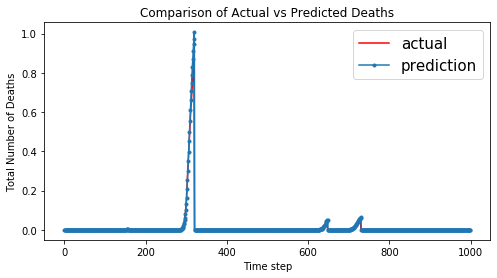

In [20]:
Range=[x for x in range(1000)]
plt.figure(figsize=(8,4))
plt.plot(Range, inv_validation_fatalities[:1000],'r' , label="actual")
plt.plot(Range, inv_pred_fatal[:1000], marker='.', label="prediction")
plt.ylabel('Total Number of Deaths')
plt.xlabel('Time step')
plt.title('Comparison of Actual vs Predicted Deaths')
plt.legend(fontsize=15)
plt.show()

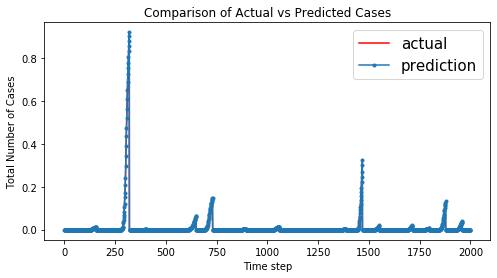

In [22]:
Range=[x for x in range(2000)]
plt.figure(figsize=(8,4))
plt.plot(Range, inv_validation_case[:2000],'r' , label="actual")
plt.plot(Range, inv_pred_case[:2000], marker='.', label="prediction")
plt.ylabel('Total Number of Cases')
plt.xlabel('Time step')
plt.title('Comparison of Actual vs Predicted Cases')
plt.legend(fontsize=15)
plt.show()